**Import all imoprtant models**

In [ ]:
# Basic modules
import pandas as pd
import numpy as np
import pickle
import gc # for garbage collection
import matplotlib.pyplot as plt
from datetime import datetime,date
from scipy.stats import norm,skew
from collections import Counter
# metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
import lightgbm as lgb
#Folds
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
#cross_validations
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
#Modules for processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
#for ignorance of warning
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

**Load the data**

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,lb;q=0.8,ru;q=0.7,es;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10445/200747/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603596582&Signature=FtlP07xJ4y3Rsbt09FPH3Qd6TLMPK549tRRybYkS8qSmDOOkH2LyCmtIQC6regTirKxDmJmL9zuj9ZD3JjihB4D%2FHC%2BWmab05LjJHbZF6BO0vYS8MG0yzoUtUVL%2BmiV29EFJgU%2By%2B9KmkwvA%2BMSOMUJ7lwmomLU8KXb%2F8pTeqXlimiIDT4akQ%2Bgn8uD5czg%2FD8n0JxB7xyF9muGkfWi6B3IlNi4%2BS%2BOrAtvVa7UOEeQZqd7bqoXzTMcvvz2z3%2Fma7bayWboBWhkCa6iOwfWw%2BjF%2F4EQRQkezYV6qEf8UR5Xyt0sE8nvYvGQ9sQg%2BuaYJ2oGzBGzkz4sA%2BB16sIp%2FTg%3D%3D&response-content-disposition=attachment%3B+filename%3Delo-merchant-category-recommendation.zip" -c -O 'elo-merchant-category-recommendation.zip'

--2020-10-22 03:30:25--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10445/200747/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603596582&Signature=FtlP07xJ4y3Rsbt09FPH3Qd6TLMPK549tRRybYkS8qSmDOOkH2LyCmtIQC6regTirKxDmJmL9zuj9ZD3JjihB4D%2FHC%2BWmab05LjJHbZF6BO0vYS8MG0yzoUtUVL%2BmiV29EFJgU%2By%2B9KmkwvA%2BMSOMUJ7lwmomLU8KXb%2F8pTeqXlimiIDT4akQ%2Bgn8uD5czg%2FD8n0JxB7xyF9muGkfWi6B3IlNi4%2BS%2BOrAtvVa7UOEeQZqd7bqoXzTMcvvz2z3%2Fma7bayWboBWhkCa6iOwfWw%2BjF%2F4EQRQkezYV6qEf8UR5Xyt0sE8nvYvGQ9sQg%2BuaYJ2oGzBGzkz4sA%2BB16sIp%2FTg%3D%3D&response-content-disposition=attachment%3B+filename%3Delo-merchant-category-recommendation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.217.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644665605 (615M) [application/zip]
Saving 

In [ ]:
!unzip elo-merchant-category-recommendation.zip

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


**1. Feature Engineering**

**1.1 Function for reducing the memory usage**

In [ ]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
#determine and apply the smallest data type that can fit the range of values
def memory_reduce(data_frame,verbose=True):
  numerals=['int16','int32','int64','float16','float32','float64']# Here we define the datatypes numerals.
  initial_memory_usage=data_frame.memory_usage().sum()/ 1024**2# here we first calculate the memory usage by each feature and then sum up all the memory usage of all features in dataframe. Then we divide it by 2 power 12. So that memory usage will decrease by the dataframe.
  for k in data_frame.columns:#for each column in each dataframe
    datatype_feature= data_frame[k].dtypes# Here we found out the datatypes of each feature in dataframe.
    if datatype_feature in numerals:# Here we check the feature lies in the category of numerics feature.
      minimum_feature_value= data_frame[k].min()# if the feature is in numerics then first we get the  minimum of that feature.
      maximum_feature_value= data_frame[k].max()# if the feature is in numerics then first we get the  maximum of that feature.
      if str(datatype_feature)[:3]== 'int':#  Here we check that third feature is integer feature or not.
        if minimum_feature_value > np.iinfo(np.int8).min and maximum_feature_value < np.iinfo(np.int8).max:# IF integer values is in the between of c_min and c_max and have the value of int8.means of (-128 to 127).
          data_frame[k]= data_frame[k].astype(np.int8)# here simple we assign the int8 value in his corresponding integer value feature.
        elif minimum_feature_value > np.iinfo(np.int16).min and maximum_feature_value < np.iinfo(np.int16).max:# Here simple we check for the int16 means(-32,768 to 32,767) bit range.
          data_frame[k]= data_frame[k].astype(np.int16)# Here we assign the int16 values.  
        elif minimum_feature_value > np.iinfo(np.int32).min and maximum_feature_value < np.iinfo(np.int32).max:# Here for int32 means(-2,147,483,648 to 2,147,483,647) bit range.
          data_frame[k]= data_frame[k].astype(np.int32)#  Here we assign the int32 values.
        elif minimum_feature_value > np.iinfo(np.int64).min and maximum_feature_value < np.iinfo(np.int64).max:# here we assign the int64 means(-9,223,372,036,854,775,808 to 9,223,372,036,854,775,807) bit range.
          data_frame[k]= data_frame[k].astype(np.int64)# Here we assign the int64 values.
      else:  
        if minimum_feature_value > np.finfo(np.float16).min and maximum_feature_value < np.finfo(np.float16).max:# Otherwise if it is the float16 values range
          data_frame[k]= data_frame[k].astype(np.float16)# assign it corresponding values.
        elif minimum_feature_value > np.finfo(np.float32).min and maximum_feature_value < np.finfo(np.float32).max:# Here we check the min and max range of float 32 values.
          data_frame[k]= data_frame[k].astype(np.float32)# assign the corresponding values.
        else:
          data_frame[k] = data_frame[k].astype(np.float64)# similarly for int64. 
  final_memory_usage= data_frame.memory_usage().sum()/1024**2# Here we again decrease the memory usage of each feature after separating the corresponding bit integer and float values
  if verbose:
    print(' The  decrease in memory usage from {:5.2f}MB to ({:.1f}% reduction)'.format(final_memory_usage,100* (initial_memory_usage-final_memory_usage)/initial_memory_usage))# Here we find out the difference between the memory decrease from the starting and end memory usage.
  return data_frame

**1.2 Load train and test data**

In [ ]:
data_frame_train = pd.read_csv('train.csv')# Read the train file
data_frame_test = pd.read_csv('test.csv')# Read the test file

**1.3 Add features in train and test data**

In [ ]:
data_frame_train['outliers'] = 0
data_frame_train.loc[data_frame_train['target'] < -30, 'outliers'] = 1
data_frame_train['outliers'].value_counts()
# Here we are doing mean encoding for features with outliers
for k in ['feature_1','feature_2','feature_3']:
  label = data_frame_train.groupby([k])['outliers'].mean()
  data_frame_train[k+"_mean"] = data_frame_train[k].map(label) 
# Now extract the days and Qtr
sr = pd.Series(data_frame_train['first_active_month'])# Convert the first active month in series format
sr=pd.to_datetime(sr)
data_frame_train['days'] = (date(2018, 2,1) - sr.dt.date).dt.days# just having error so we first try the numeric method
data_frame_train['quarter'] = sr.dt.quarter# here we get the quarter.
k_cols = ['feature_1', 'feature_2', 'feature_3']
for i in k_cols:
  data_frame_train['days_' + i] = data_frame_train['days'] * data_frame_train[i]
  data_frame_train['days_' + i + '_ratio'] = data_frame_train[i] / data_frame_train['days']
gc.collect()

56

In [ ]:
# Here we are doing mean encoding for features with outliers
for k in ['feature_1','feature_2','feature_3']:
  label = data_frame_train.groupby([k])['outliers'].mean()
  data_frame_test[k+"_mean"] = data_frame_test[k].map(label) 
# Now extract the days and Qtr
sr = pd.Series(data_frame_test['first_active_month'])# Convert the first active month in series format
sr=pd.to_datetime(sr)
data_frame_test['days'] = (date(2018, 2,1) - sr.dt.date).dt.days# just having error so we first try the numeric method
data_frame_test['quarter'] = sr.dt.quarter# here we get the quarter.
k_cols = ['feature_1', 'feature_2', 'feature_3']
for i in k_cols:
  data_frame_test['days_' + i] = data_frame_test['days'] * data_frame_test[i]
  data_frame_test['days_' + i + '_ratio'] = data_frame_test[i] / data_frame_test['days']
gc.collect()

23

**1.4 Here we read all the remain files**

In [ ]:
df_hist_trans = pd.read_csv('historical_transactions.csv')# read historical transaction files
df_hist_trans=memory_reduce(df_hist_trans)# reduce the memory usage of historical transaction
df_hist_trans.replace([-np.inf,np.inf],np.nan,inplace=True)# replace the -inf,inf to nan values
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')# read the new merchants transactions files
df_new_merchant_trans=memory_reduce(df_new_merchant_trans)# reduce the memory usage of new merchants transactions files
df_new_merchant_trans.replace([-np.inf,np.inf],np.nan,inplace=True)# replace -inf,inf with nan values in new merchants files.
df_merchant_trans=pd.read_csv('/content/merchants.csv')# read the merchants files
df_merchant_trans=memory_reduce(df_merchant_trans)# reduce the memory usage of merchants files
df_merchant_trans.replace([-np.inf,np.inf],np.nan,inplace=True)# replace the -inf, inf with nan in merchants files.

 The  decrease in memory usage from 1749.11MB to (43.7% reduction)
 The  decrease in memory usage from 114.20MB to (45.5% reduction)
 The  decrease in memory usage from 30.32MB to (46.0% reduction)


**1.5 Impute missing values in historical transaction features**

In [ ]:
df_hist_trans['category_2'] = df_hist_trans['category_2'].fillna(1,inplace=True)
df_hist_trans['category_3'] = df_hist_trans['category_3'].fillna('A',inplace=True)
df_hist_trans['merchant_id'] = df_hist_trans['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
df_hist_trans['installments'].replace(-1, np.nan,inplace=True)
df_hist_trans['installments'].replace(999, np.nan,inplace=True)
df_hist_trans['purchase_amount'] = df_hist_trans['purchase_amount'].apply(lambda x: min(x, 0.8))

**1.6 Impute missing values in new merchants transaction file**

In [ ]:
df_new_merchant_trans['category_2'] = df_new_merchant_trans['category_2'].fillna(1,inplace=True)
df_new_merchant_trans['category_3'] = df_new_merchant_trans['category_3'].fillna('A',inplace=True)
df_new_merchant_trans['merchant_id'] = df_new_merchant_trans['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
df_new_merchant_trans['installments'].replace(-1, np.nan,inplace=True)
df_new_merchant_trans['installments'].replace(999, np.nan,inplace=True)
df_new_merchant_trans['purchase_amount'] = df_new_merchant_trans['purchase_amount'].apply(lambda x: min(x, 0.8))

**1.6 function for getting the feature names**

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

**1.7 Here we make the features for historical transactions**

In [ ]:
# Transform A,B,C and Y, N into numerical form 1,2,3
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'A':0, 'B':1, 'C':2})
# Get the purchase date of the historical transaction
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
#Here we get the week ordinal of the year
df_hist_trans['weekofyear'] = df_hist_trans['purchase_date'].dt.weekofyear
df_hist_trans['month'] = df_hist_trans['purchase_date'].dt.month# get the month
df_hist_trans['day'] = df_hist_trans['purchase_date'].dt.day# get the day
df_hist_trans['weekday'] = df_hist_trans.purchase_date.dt.weekday# get the week day
df_hist_trans['weekend'] = (df_hist_trans.purchase_date.dt.weekday >=5).astype(int)# weekend
df_hist_trans['hour'] =df_hist_trans['purchase_date'].dt.hour# hour from the purchase date 
# month diff is subtraction of purchase date from the today date
df_hist_trans['month_diff'] = ((datetime.today() - df_hist_trans['purchase_date']).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']
# Here we get the duration when we multipluy the purchase amount and month_diff
df_hist_trans['duration'] = df_hist_trans['purchase_amount']*df_hist_trans['month_diff']
#amount_month ratio is when we divide the purchase amount from month_diff
df_hist_trans['amount_month_ratio'] = df_hist_trans['purchase_amount']/df_hist_trans['month_diff']
# price is when we divide the purchase amount from installments
df_hist_trans['price'] = df_hist_trans['purchase_amount'] / df_hist_trans['installments']
gc.collect()

60

**1.8 Here we make the features for new historical transactions**

In [ ]:
# Transform A,B,C and Y, N into numerical form 1,2,3
df_new_merchant_trans['authorized_flag'] = df_new_merchant_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_merchant_trans['category_1'] = df_new_merchant_trans['category_1'].map({'Y': 1, 'N': 0})
df_new_merchant_trans['category_3'] = df_new_merchant_trans['category_3'].map({'A':0, 'B':1, 'C':2})
# Get the purchase date of the historical transaction
df_new_merchant_trans['purchase_date'] = pd.to_datetime(df_new_merchant_trans['purchase_date'])
#Here we get the week ordinal of the year
df_new_merchant_trans['weekofyear'] = df_new_merchant_trans['purchase_date'].dt.weekofyear
df_new_merchant_trans['month'] = df_new_merchant_trans['purchase_date'].dt.month# get the month
df_new_merchant_trans['day'] = df_new_merchant_trans['purchase_date'].dt.day# get the day
df_new_merchant_trans['weekday'] = df_new_merchant_trans.purchase_date.dt.weekday# get the week day
df_new_merchant_trans['weekend'] = (df_new_merchant_trans.purchase_date.dt.weekday >=5).astype(int)# weekend
df_new_merchant_trans['hour'] =df_new_merchant_trans['purchase_date'].dt.hour# hour from the purchase date 
# month diff is subtraction of purchase date from the today date
df_new_merchant_trans['month_diff'] = ((datetime.today() - df_new_merchant_trans['purchase_date']).dt.days)//30
df_new_merchant_trans['month_diff'] += df_new_merchant_trans['month_lag']
# Here we get the duration when we multipluy the purchase amount and month_diff
df_new_merchant_trans['duration'] = df_new_merchant_trans['purchase_amount']*df_new_merchant_trans['month_diff']
#amount_month ratio is when we divide the purchase amount from month_diff
df_new_merchant_trans['amount_month_ratio'] = df_new_merchant_trans['purchase_amount']/df_new_merchant_trans['month_diff']
# price is when we divide the purchase amount from installments
df_new_merchant_trans['price'] = df_new_merchant_trans['purchase_amount'] / df_new_merchant_trans['installments']
gc.collect()

21

**1.9 Aggregate the historical transactions features**

In [ ]:
aggs = {}# here we aggregate all the values of sum,min,max,mean,var,skew for all the features
aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff']=['max','min','mean','var','skew']
aggs['weekend'] = ['sum', 'mean']
aggs['weekday'] = ['sum', 'mean']
aggs['authorized_flag']= ['sum', 'mean']
aggs['category_1']= ['sum','mean', 'max','min']
aggs['card_id'] = ['size','count']
aggs['month']= ['nunique', 'mean', 'min', 'max']
aggs['hour']= ['nunique', 'mean', 'min', 'max']
aggs['weekofyear']= ['nunique', 'mean', 'min', 'max']
aggs['day']= ['nunique', 'mean', 'min', 'max']
aggs['subsector_id']= ['nunique']
aggs['merchant_id']= ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['price'] =['sum','mean','max','min','var']
aggs['duration'] = ['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']
# here we try to aggregate all the mean,max,min,sum into category_2, category_3.
for col in ['category_2','category_3']:
  df_hist_trans[col+'_mean'] = df_hist_trans.groupby(df_hist_trans[col])['purchase_amount'].agg('mean')
  df_hist_trans[col+'_max'] = df_hist_trans.groupby(df_hist_trans[col])['purchase_amount'].agg('max')
  df_hist_trans[col+'_min'] = df_hist_trans.groupby(df_hist_trans[col])['purchase_amount'].agg('min')
  df_hist_trans[col+'_sum'] = df_hist_trans.groupby(df_hist_trans[col])['purchase_amount'].agg('sum')
  aggs[col+'_mean'] = ['mean']
gc.collect()      
# here we groupby the features by card_id and have new features.
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby(['card_id']).agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
data_frame_train = data_frame_train.merge(df_hist_trans_group,on='card_id',how='left')
data_frame_test = data_frame_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

0

**1.10 delete this features because they contain only nan values**

In [ ]:
data_frame_train=data_frame_train.drop(['hist_category_2_mean_mean','hist_category_3_mean_mean'],axis=1)
data_frame_test=data_frame_test.drop(['hist_category_2_mean_mean','hist_category_3_mean_mean'],axis=1)

**1.11  Aggregate the new merchants transactions features**

In [ ]:
aggs = {}# here we aggregate all the values of sum,min,max,mean,var,skew for all the features
aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff']=['max','min','mean','var','skew']
aggs['weekend'] = ['sum', 'mean']
aggs['weekday'] = ['sum', 'mean']
aggs['authorized_flag']= ['sum', 'mean']
aggs['category_1']= ['sum','mean', 'max','min']
aggs['card_id'] = ['size','count']
aggs['month']= ['nunique', 'mean', 'min', 'max']
aggs['hour']= ['nunique', 'mean', 'min', 'max']
aggs['weekofyear']= ['nunique', 'mean', 'min', 'max']
aggs['day']= ['nunique', 'mean', 'min', 'max']
aggs['subsector_id']= ['nunique']
aggs['merchant_id']= ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['price'] =['sum','mean','max','min','var']
aggs['duration'] = ['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']
# here we try to aggregate all the mean,max,min,sum into category_2, category_3.
for col in ['category_2','category_3']:
  df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby(df_new_merchant_trans[col])['purchase_amount'].agg('mean')
  df_new_merchant_trans[col+'_max'] = df_new_merchant_trans.groupby(df_new_merchant_trans[col])['purchase_amount'].agg('max')
  df_new_merchant_trans[col+'_min'] = df_new_merchant_trans.groupby(df_new_merchant_trans[col])['purchase_amount'].agg('min')
  df_new_merchant_trans[col+'_sum'] = df_new_merchant_trans.groupby(df_new_merchant_trans[col])['purchase_amount'].agg('sum')
  aggs[col+'_mean'] = ['mean']
gc.collect()      
# here we groupby the features by card_id and have new features.
new_columns = get_new_columns('new_hist',aggs)
df_new_merchant_trans_group = df_new_merchant_trans.groupby(['card_id']).agg(aggs)
df_new_merchant_trans_group.columns = new_columns
df_new_merchant_trans_group.reset_index(drop=False,inplace=True)
data_frame_train = data_frame_train.merge(df_new_merchant_trans_group,on='card_id',how='left')
data_frame_test = data_frame_test.merge(df_new_merchant_trans_group,on='card_id',how='left')
del df_new_merchant_trans_group;gc.collect()

0

**1.12 delete this features because they contain only nan values**

In [ ]:
data_frame_train=data_frame_train.drop(['new_hist_category_2_mean_mean','new_hist_category_3_mean_mean'],axis=1)
data_frame_test=data_frame_test.drop(['new_hist_category_2_mean_mean','new_hist_category_3_mean_mean'],axis=1)

**1.13 Additional features which is inducted in train data**

In [ ]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
data_frame_train['hist_purchase_date_max'] = pd.to_datetime(data_frame_train['hist_purchase_date_max'])
data_frame_train['hist_purchase_date_min'] = pd.to_datetime(data_frame_train['hist_purchase_date_min'])
data_frame_train['hist_purchase_date_diff'] = (data_frame_train['hist_purchase_date_max'] - data_frame_train['hist_purchase_date_min']).dt.days
data_frame_train['hist_purchase_date_average'] = data_frame_train['hist_purchase_date_diff']/data_frame_train['hist_card_id_size']
data_frame_train['hist_purchase_date_uptonow'] = (datetime.today() - data_frame_train['hist_purchase_date_max']).dt.days
data_frame_train['hist_purchase_date_uptomin'] = (datetime.today() - data_frame_train['hist_purchase_date_min']).dt.days
sr = pd.Series(data_frame_train['first_active_month'])
sr=pd.to_datetime(sr)
data_frame_train['hist_first_buy'] = (data_frame_train['hist_purchase_date_min'] - sr).dt.days
data_frame_train['hist_last_buy'] = (data_frame_train['hist_purchase_date_max'] - sr).dt.days

# here we convert this features in integer format for training in historical data.
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
  data_frame_train[feature] = data_frame_train[feature].astype(np.int64) * 1e-9
  
# Additional features 
# https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending 
data_frame_train['new_hist_purchase_date_max'] = pd.to_datetime(data_frame_train['new_hist_purchase_date_max'])
data_frame_train['new_hist_purchase_date_min'] = pd.to_datetime(data_frame_train['new_hist_purchase_date_min'])
data_frame_train['new_hist_purchase_date_diff'] = (data_frame_train['new_hist_purchase_date_max'] - data_frame_train['new_hist_purchase_date_min']).dt.days
data_frame_train['new_hist_purchase_date_average'] = data_frame_train['new_hist_purchase_date_diff']/data_frame_train['new_hist_card_id_size']
data_frame_train['new_hist_purchase_date_uptonow'] = (datetime.today() - data_frame_train['new_hist_purchase_date_max']).dt.days
data_frame_train['new_hist_purchase_date_uptomin'] = (datetime.today() - data_frame_train['new_hist_purchase_date_min']).dt.days
sr = pd.Series(data_frame_train['first_active_month'])
sr=pd.to_datetime(sr)
data_frame_train['new_first_buy'] = (data_frame_train['new_hist_purchase_date_min'] - sr).dt.days
data_frame_train['new_last_buy'] = (data_frame_train['new_hist_purchase_date_max'] - sr).dt.days
data_frame_train['new_hist_purchase_date_max'] = pd.to_numeric(data_frame_train['new_hist_purchase_date_max'], errors='coerce')
data_frame_train['new_hist_purchase_date_min'] = pd.to_numeric(data_frame_train['new_hist_purchase_date_min'], errors='coerce')
data_frame_train = data_frame_train.dropna(subset=['new_hist_purchase_date_max'])
data_frame_train = data_frame_train.dropna(subset=['new_hist_purchase_date_min'])
# here we convert this features in integer format for training in new historical data.
for feature in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
  data_frame_train[feature] = data_frame_train[feature].astype(np.int64) * 1e-9    
  gc.collect()
  
data_frame_train['card_id_total'] = data_frame_train['new_hist_card_id_size']+data_frame_train['hist_card_id_size']
data_frame_train['card_id_cnt_total'] = data_frame_train['new_hist_card_id_count']+data_frame_train['hist_card_id_count']
data_frame_train['card_id_cnt_ratio'] = data_frame_train['new_hist_card_id_count']/data_frame_train['hist_card_id_count']
data_frame_train['purchase_amount_total'] = data_frame_train['new_hist_purchase_amount_sum']+data_frame_train['hist_purchase_amount_sum']
data_frame_train['purchase_amount_mean'] = data_frame_train['new_hist_purchase_amount_mean']+data_frame_train['hist_purchase_amount_mean']
data_frame_train['purchase_amount_max'] = data_frame_train['new_hist_purchase_amount_max']+data_frame_train['hist_purchase_amount_max']
data_frame_train['purchase_amount_min'] = data_frame_train['new_hist_purchase_amount_min']+data_frame_train['hist_purchase_amount_min']
data_frame_train['purchase_amount_ratio'] = data_frame_train['new_hist_purchase_amount_sum']/data_frame_train['hist_purchase_amount_sum']
data_frame_train['month_diff_mean'] = data_frame_train['new_hist_month_diff_mean']+data_frame_train['hist_month_diff_mean']
data_frame_train['month_diff_ratio'] = data_frame_train['new_hist_month_diff_mean']/data_frame_train['hist_month_diff_mean']
data_frame_train['month_lag_mean'] = data_frame_train['new_hist_month_lag_mean']+data_frame_train['hist_month_lag_mean']
data_frame_train['month_lag_max'] = data_frame_train['new_hist_month_lag_max']+data_frame_train['hist_month_lag_max']
data_frame_train['month_lag_min'] = data_frame_train['new_hist_month_lag_min']+data_frame_train['hist_month_lag_min']
data_frame_train['category_1_mean'] = data_frame_train['new_hist_category_1_mean']+data_frame_train['hist_category_1_mean']
data_frame_train['installments_total'] = data_frame_train['new_hist_installments_sum']+data_frame_train['hist_installments_sum']
data_frame_train['installments_mean'] = data_frame_train['new_hist_installments_mean']+data_frame_train['hist_installments_mean']
data_frame_train['installments_max'] = data_frame_train['new_hist_installments_max']+data_frame_train['hist_installments_max']
data_frame_train['installments_ratio'] = data_frame_train['new_hist_installments_sum']/data_frame_train['hist_installments_sum']
data_frame_train['price_total'] = data_frame_train['purchase_amount_total'] / data_frame_train['installments_total']
data_frame_train['price_mean'] = data_frame_train['purchase_amount_mean'] / data_frame_train['installments_mean']
data_frame_train['price_max'] =data_frame_train['purchase_amount_max'] / data_frame_train['installments_max']
data_frame_train['duration_mean'] = data_frame_train['new_hist_duration_mean']+data_frame_train['hist_duration_mean']
data_frame_train['duration_min'] = data_frame_train['new_hist_duration_min']+data_frame_train['hist_duration_min']
data_frame_train['duration_max'] = data_frame_train['new_hist_duration_max']+data_frame_train['hist_duration_max']
data_frame_train['amount_month_ratio_mean']=data_frame_train['new_hist_amount_month_ratio_mean']+data_frame_train['hist_amount_month_ratio_mean']
data_frame_train['amount_month_ratio_min']=data_frame_train['new_hist_amount_month_ratio_min']+data_frame_train['hist_amount_month_ratio_min']
data_frame_train['amount_month_ratio_max']=data_frame_train['new_hist_amount_month_ratio_max']+data_frame_train['hist_amount_month_ratio_max']
data_frame_train['new_CLV'] = data_frame_train['new_hist_card_id_count'] * data_frame_train['new_hist_purchase_amount_sum'] / data_frame_train['new_hist_month_diff_mean']
data_frame_train['hist_CLV'] =data_frame_train['hist_card_id_count'] * data_frame_train['hist_purchase_amount_sum'] / data_frame_train['hist_month_diff_mean']
data_frame_train['CLV_ratio'] = data_frame_train['new_CLV'] / data_frame_train['hist_CLV']
gc.collect()


13

**1.14  Additional features which is inducted in test data**

In [ ]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
data_frame_test['hist_purchase_date_max'] = pd.to_datetime(data_frame_test['hist_purchase_date_max'])
data_frame_test['hist_purchase_date_min'] = pd.to_datetime(data_frame_test['hist_purchase_date_min'])
data_frame_test['hist_purchase_date_diff'] = (data_frame_test['hist_purchase_date_max'] - data_frame_test['hist_purchase_date_min']).dt.days
data_frame_test['hist_purchase_date_average'] = data_frame_test['hist_purchase_date_diff']/data_frame_test['hist_card_id_size']
data_frame_test['hist_purchase_date_uptonow'] = (datetime.today() - data_frame_test['hist_purchase_date_max']).dt.days
data_frame_test['hist_purchase_date_uptomin'] = (datetime.today() - data_frame_test['hist_purchase_date_min']).dt.days
sr = pd.Series(data_frame_test['first_active_month'])
sr=pd.to_datetime(sr)
data_frame_test['hist_first_buy'] = (data_frame_test['hist_purchase_date_min'] - sr).dt.days
data_frame_test['hist_last_buy'] = (data_frame_test['hist_purchase_date_max'] - sr).dt.days
# here we convert this features in integer format for training in historical data.
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
  data_frame_test[feature] = data_frame_test[feature].astype(np.int64) * 1e-9
  
  
data_frame_test['new_hist_purchase_date_max'] = pd.to_datetime(data_frame_test['new_hist_purchase_date_max'])
data_frame_test['new_hist_purchase_date_min'] = pd.to_datetime(data_frame_test['new_hist_purchase_date_min'])
data_frame_test['new_hist_purchase_date_diff'] = (data_frame_test['new_hist_purchase_date_max'] - data_frame_test['new_hist_purchase_date_min']).dt.days
data_frame_test['new_hist_purchase_date_average'] = data_frame_test['new_hist_purchase_date_diff']/data_frame_test['new_hist_card_id_size']
data_frame_test['new_hist_purchase_date_uptonow'] = (datetime.today() - data_frame_test['new_hist_purchase_date_max']).dt.days
data_frame_test['new_hist_purchase_date_uptomin'] = (datetime.today() - data_frame_test['new_hist_purchase_date_min']).dt.days
sr = pd.Series(data_frame_test['first_active_month'])
sr=pd.to_datetime(sr)
data_frame_test['new_first_buy'] = (data_frame_test['new_hist_purchase_date_min'] - sr).dt.days
data_frame_test['new_last_buy'] = (data_frame_test['new_hist_purchase_date_max'] - sr).dt.days
data_frame_test['new_hist_purchase_date_max'] = pd.to_numeric(data_frame_test['new_hist_purchase_date_max'], errors='coerce')
data_frame_test['new_hist_purchase_date_min'] = pd.to_numeric(data_frame_test['new_hist_purchase_date_min'], errors='coerce')
data_frame_test = data_frame_test.dropna(subset=['new_hist_purchase_date_max'])
data_frame_test = data_frame_test.dropna(subset=['new_hist_purchase_date_min'])
# here we convert this features in integer format for training in historical data.
for feature in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
  data_frame_test[feature] = data_frame_test[feature].astype(np.int64) * 1e-9    
  gc.collect()

# Additional features 
# https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending  
data_frame_test['card_id_total'] = data_frame_test['new_hist_card_id_size']+data_frame_test['hist_card_id_size']
data_frame_test['card_id_cnt_total'] = data_frame_test['new_hist_card_id_count']+data_frame_test['hist_card_id_count']
data_frame_test['card_id_cnt_ratio'] = data_frame_test['new_hist_card_id_count']/data_frame_test['hist_card_id_count']
data_frame_test['purchase_amount_total'] = data_frame_test['new_hist_purchase_amount_sum']+data_frame_test['hist_purchase_amount_sum']
data_frame_test['purchase_amount_mean'] = data_frame_test['new_hist_purchase_amount_mean']+data_frame_test['hist_purchase_amount_mean']
data_frame_test['purchase_amount_max'] = data_frame_test['new_hist_purchase_amount_max']+data_frame_test['hist_purchase_amount_max']
data_frame_test['purchase_amount_min'] = data_frame_test['new_hist_purchase_amount_min']+data_frame_test['hist_purchase_amount_min']
data_frame_test['purchase_amount_ratio'] = data_frame_test['new_hist_purchase_amount_sum']/data_frame_test['hist_purchase_amount_sum']
data_frame_test['month_diff_mean'] = data_frame_test['new_hist_month_diff_mean']+data_frame_test['hist_month_diff_mean']
data_frame_test['month_diff_ratio'] = data_frame_test['new_hist_month_diff_mean']/data_frame_test['hist_month_diff_mean']
data_frame_test['month_lag_mean'] = data_frame_test['new_hist_month_lag_mean']+data_frame_test['hist_month_lag_mean']
data_frame_test['month_lag_max'] = data_frame_test['new_hist_month_lag_max']+data_frame_test['hist_month_lag_max']
data_frame_test['month_lag_min'] = data_frame_test['new_hist_month_lag_min']+data_frame_test['hist_month_lag_min']
data_frame_test['category_1_mean'] = data_frame_test['new_hist_category_1_mean']+data_frame_test['hist_category_1_mean']
data_frame_test['installments_total'] = data_frame_test['new_hist_installments_sum']+data_frame_test['hist_installments_sum']
data_frame_test['installments_mean'] = data_frame_test['new_hist_installments_mean']+data_frame_test['hist_installments_mean']
data_frame_test['installments_max'] = data_frame_test['new_hist_installments_max']+data_frame_test['hist_installments_max']
data_frame_test['installments_ratio'] = data_frame_test['new_hist_installments_sum']/data_frame_test['hist_installments_sum']
data_frame_test['price_total'] = data_frame_test['purchase_amount_total'] / data_frame_test['installments_total']
data_frame_test['price_mean'] = data_frame_test['purchase_amount_mean'] / data_frame_test['installments_mean']
data_frame_test['price_max'] =data_frame_test['purchase_amount_max'] / data_frame_test['installments_max']
data_frame_test['duration_mean'] = data_frame_test['new_hist_duration_mean']+data_frame_test['hist_duration_mean']
data_frame_test['duration_min'] = data_frame_test['new_hist_duration_min']+data_frame_test['hist_duration_min']
data_frame_test['duration_max'] = data_frame_test['new_hist_duration_max']+data_frame_test['hist_duration_max']
data_frame_test['amount_month_ratio_mean']=data_frame_test['new_hist_amount_month_ratio_mean']+data_frame_test['hist_amount_month_ratio_mean']
data_frame_test['amount_month_ratio_min']=data_frame_test['new_hist_amount_month_ratio_min']+data_frame_test['hist_amount_month_ratio_min']
data_frame_test['amount_month_ratio_max']=data_frame_test['new_hist_amount_month_ratio_max']+data_frame_test['hist_amount_month_ratio_max']
data_frame_test['new_CLV'] = data_frame_test['new_hist_card_id_count'] * data_frame_test['new_hist_purchase_amount_sum'] / data_frame_test['new_hist_month_diff_mean']
data_frame_test['hist_CLV'] =data_frame_test['hist_card_id_count'] * data_frame_test['hist_purchase_amount_sum'] / data_frame_test['hist_month_diff_mean']
data_frame_test['CLV_ratio'] = data_frame_test['new_CLV'] / data_frame_test['hist_CLV']
gc.collect()


0

**2 Here we try to aggregate the merchant data in the train and test data to have more features and add information for training**

**2.1 Agggregate the merchant data**

In [ ]:
def aggregation_merchants(merchants):
  second_mode=lambda x: Counter(x).most_common(1)[0][0]#Counting the most common element and take it as second mode.
  # here we aggregate all the features of merchants with most common element and groupby according to merchant id.
  group_merchants=merchants.groupby('merchant_id',as_index=False).agg({
        "merchant_group_id": second_mode,
        "merchant_category_id": second_mode,
        "subsector_id": second_mode,
        "numerical_1": "mean",
        "numerical_2": "mean",
        "category_1": second_mode,
        "most_recent_sales_range": second_mode,
        "most_recent_purchases_range": second_mode,
        "avg_sales_lag3": "mean",
        "avg_purchases_lag3": "mean",
        "active_months_lag3": second_mode,
        "avg_sales_lag6": "mean",
        "avg_purchases_lag6": "mean",
        "active_months_lag6": second_mode,
        "avg_sales_lag12": "mean",
        "avg_purchases_lag12": "mean",
        "active_months_lag12": second_mode,
        "category_4": second_mode,
        "city_id": second_mode,
        "state_id": second_mode,
        "category_2": second_mode
  })
  return group_merchants

**2.2 Aggregate the new merchnat data**

In [ ]:
# here we again aggregate the card_id because there are some dulplicate card_id.
# here we aggregate the mean in numerical features of new merchants.
def aggregation_transactions(transactions):
    second_mode = lambda x: Counter(x).most_common(1)[0][0]#Counting the most common element and take it as second mode.
    # here we aggregate all the features of merchants with most common element and groupby according to merchant id.
    group_transactions = transactions.groupby("card_id",as_index=False).agg({
        "authorized_flag": second_mode,
        "merchant_category_id": second_mode,
        "subsector_id": second_mode,
        "merchant_id":  second_mode,
        "category_1": second_mode,
        'month_lag': second_mode,
        "installments": second_mode,
        "purchase_amount": "mean",
        "city_id": second_mode,
        "state_id": second_mode,
        "category_2": second_mode,
        "purchase_date": second_mode
    })
    return group_transactions
  

**2.3 function for encoding train and test data**

In [ ]:
#https://medium.com/@narender.buchireddy/elo-merchant-category-recommendation-competition-on-kaggle-lightgbm-implementation-a-case-83b0912fa7f3
def encoding_train(data_frame_train, transactions, merchants, suffix):
  transactions=aggregation_transactions(transactions)# here we pass the new transactions data into the function to aggregate the most common values.
  transactions.columns= [k+suffix if k not in ['card_id','merchant_id'] else k for k in transactions.columns]# here we try to get the colmns based on card_id and merchant_id.
  # here we merge the train data with the most common new transactions feature values based 0on card_id.
  transactions_train=pd.merge(data_frame_train['card_id'],transactions,on='card_id',how='left')
  del transactions# because we do not need that in future.



  # merge the transaction and merchant data.
  merchants = aggregation_merchants(merchants)# here we aggregate the merchant data.
  # get the feature value on merchant_id
  merchants.columns=[k+'_merchants'+suffix if k!='merchant_id' else k for k in merchants.columns]#
  # here we merge the transaction_train with merchnats on the basis on merchant_id.
  merge_merchants_transactions= pd.merge(transactions_train,merchants,on='merchant_id',how='left')
  del merchants# delete the merchants because we have merge form of all the data.
  del transactions_train# no need 
  del merge_merchants_transactions['merchant_id']# no need


  data_frame_train_card_id= data_frame_train['card_id'].unique()# here we take the unique card_id of train data.
  # check whether card_id is found is in all merge data of transactions and merchants.
  INDEX= merge_merchants_transactions['card_id'].isin(list(data_frame_train_card_id))
  # filter the merge data for the unique card_id so that we are safe from duplicate card_id.
  merge_merchants_transactions_unique=merge_merchants_transactions.loc[INDEX]
  # Have the corresponding target value in card_id in merge merchant and transcations data.
  merge_merchants_transactions_unique_label=merge_merchants_transactions_unique.merge(data_frame_train[['card_id','target']],how='left',left_on='card_id',right_on='card_id')
  del merge_merchants_transactions_unique
  gc.collect()

  # here we impute the missing value in merge merchants transactions because there are some missing values.
  merge_merchants_transactions.fillna(-9999,inplace=True)

  # now this is the time for mean encoding in train data
  # here we add the suffix to the features to make new features so that we induct the values which we have from aggregation.
  encoding_train_features=['authorized_flag'+suffix, 'category_1'+suffix, 'month_lag'+suffix, 'installments'+suffix,'category_2'+suffix,
        'numerical_1_merchants'+suffix, 'category_1_merchants'+suffix, 'most_recent_sales_range_merchants'+suffix,
        'most_recent_purchases_range_merchants'+suffix, 'active_months_lag3_merchants'+suffix, 
        'active_months_lag6_merchants'+suffix, 'active_months_lag12_merchants'+suffix, 'category_4_merchants'+suffix,
        'category_2_merchants'+suffix]
  for i in  encoding_train_features:
    encoding= merge_merchants_transactions_unique_label.groupby(i).target.mean()
    merge_merchants_transactions[i+'_mean_encoded']= merge_merchants_transactions[i].map(encoding)
  del encoding
  gc.collect()
  return merge_merchants_transactions       

In [ ]:
#https://medium.com/@narender.buchireddy/elo-merchant-category-recommendation-competition-on-kaggle-lightgbm-implementation-a-case-83b0912fa7f3
def encoding_test(data_frame_test, transactions, merchants, suffix):
  transactions=aggregation_transactions(transactions)# here we pass the new transactions data into the function to aggregate the most common values.
  transactions.columns= [k+suffix if k not in ['card_id','merchant_id'] else k for k in transactions.columns]# here we try to get the colmns based on card_id and merchant_id.
  # here we merge the test data with the most common new transactions feature values based 0on card_id.
  transactions_test=pd.merge(data_frame_test['card_id'],transactions,on='card_id',how='left')
  del transactions# because we do not need that in future.



  # merge the transaction and merchant data.
  merchants = aggregation_merchants(merchants)# here we aggregate the merchant data.
  # get the feature value on merchant_id
  merchants.columns=[k+'_merchants'+suffix if k!='merchant_id' else k for k in merchants.columns]#
  # here we merge the transaction_train with merchnats on the basis on merchant_id.
  merge_merchants_transactions= pd.merge(transactions_test,merchants,on='merchant_id',how='left')
  del merchants# delete the merchants because we have merge form of all the data.
  del transactions_test# no need 
  del merge_merchants_transactions['merchant_id']# no need


  # here we impute the missing value in merge merchants transactions because there are some missing values.
  merge_merchants_transactions.fillna(-9999,inplace=True)
  gc.collect()
  print(' The shape of merge_merchants_transactions is: ',merge_merchants_transactions.shape)
  return merge_merchants_transactions  

**2.4 Mean Encoding for train data**

In [ ]:
print(' The data frame train shape is:',data_frame_train.shape)
print(' Here we perform the mean encoding')

# load the merchant data.
merchants = memory_reduce(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)# here we replace the -inf,inf to nan value in merchnat data.
transactions = memory_reduce(pd.read_csv('/content/new_merchant_transactions.csv',nrows=1000))
transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# Mean encoding on train data.
mean_encoding_train=encoding_train(data_frame_train, transactions, merchants, suffix='_new')
data_frame_train= pd.merge(data_frame_train,mean_encoding_train,on='card_id',how='left')
del mean_encoding_train
print(' This is the shape of data after mean encoding is:',data_frame_train.shape)


# mean encoding on merchants_historical_transactions.
merchants = memory_reduce(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)# here we replace the -inf,inf to nan value in merchnat data.
data_frame_historical_transactions=memory_reduce(pd.read_csv('/content/historical_transactions.csv',nrows=1000))
data_frame_historical_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# meaN encoding on historical_transactions
mean_encoding_hist=encoding_train(data_frame_train, data_frame_historical_transactions, merchants, suffix='_hist')
print(' We also been done by the historical mean encoding')
data_frame_train=pd.merge(data_frame_train,mean_encoding_hist, on='card_id',how='left')
del mean_encoding_hist

 The data frame train shape is: (201917, 198)
 Here we perform the mean encoding
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 This is the shape of data after mean encoding is: (201917, 244)
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 We also been done by the historical mean encoding


**2.5 Mean Encoding for test data**

In [ ]:
print(' The data frame test shape is:',data_frame_test.shape)
print(' Here we perform the mean encoding')

# load the merchant data.
merchants = memory_reduce(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)# here we replace the -inf,inf to nan value in merchnat data.
transactions = memory_reduce(pd.read_csv('/content/new_merchant_transactions.csv',nrows=1000))
transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# Mean encoding on train data.
mean_encoding_test=encoding_test(data_frame_test, transactions, merchants, suffix='_new')
data_frame_test= pd.merge(data_frame_test,mean_encoding_test,on='card_id',how='left')
del mean_encoding_test
print(' This is the shape of data after mean encoding is:',data_frame_test.shape)


# mean encoding on merchants_historical_transactions.
merchants = memory_reduce(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)# here we replace the -inf,inf to nan value in merchnat data.
data_frame_historical_transactions=memory_reduce(pd.read_csv('/content/historical_transactions.csv',nrows=1000))
data_frame_historical_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# meaN encoding on historical_transactions
mean_encoding_hist=encoding_test(data_frame_test, data_frame_historical_transactions, merchants, suffix='_hist')
print(' We also been done by the historical mean encoding')
data_frame_test=pd.merge(data_frame_test,mean_encoding_hist,on='card_id',how='left')
del mean_encoding_hist

 The data frame test shape is: (123623, 196)
 Here we perform the mean encoding
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 The shape of merge_merchants_transactions is:  (123623, 33)
 This is the shape of data after mean encoding is: (123623, 228)
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 The shape of merge_merchants_transactions is:  (123623, 33)
 We also been done by the historical mean encoding


**2.6 Here we order this features according to the target variables**

In [ ]:
columns_of_train = ['authorized_flag_new', 'category_1_new', 'month_lag_new', 'installments_new','category_2_new',
          'numerical_1_merchants_new', 'category_1_merchants_new', 'most_recent_sales_range_merchants_new',
          'most_recent_purchases_range_merchants_new', 'active_months_lag3_merchants_new', 
          'active_months_lag6_merchants_new', 'active_months_lag12_merchants_new', 'category_4_merchants_new',
          'category_2_merchants_new', 
          'authorized_flag_hist', 'category_1_hist', 'month_lag_hist', 'installments_hist', 'category_2_hist',
          'numerical_1_merchants_hist', 'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
          'most_recent_purchases_range_merchants_hist', 'active_months_lag3_merchants_hist', 
          'active_months_lag6_merchants_hist', 'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
          'category_2_merchants_hist']
           
for i in columns_of_train:
  target_in_order = data_frame_train.groupby([i])['target'].mean()# here we try to groupby the mean of target in train data so that this target map with test data.
  data_frame_test[i+"_mean_encoded"] =  data_frame_test[i].map(target_in_order)


**2.5 here we perform the one hot encoding for replacing the nan values**

In [ ]:
# one hot encoding for train data.
for i in data_frame_train.columns:# for each column in train columns.
  if data_frame_train[i].isna().any():# here we check that which column have the nan values 
    data_frame_train[i].replace([-np.inf, np.inf, np.nan], data_frame_train[i].min(), inplace=True)# here we replace the nan values with min value found in column.
# one hot encoding for test data 
for i in data_frame_test.columns:# for each column in test columns
  if data_frame_test[i].isna().any():# here we check that which column have the nan values 
    data_frame_test[i].replace([-np.inf, np.inf, np.nan], data_frame_test[i].dropna().min(), inplace=True)# here we replace the nan values with min value found in column.  
# now concate the train data with dummies(separate each string in the caller series at the passed separator) of train and test data with conversion in int type.
data_frame_train = pd.concat([data_frame_train, pd.get_dummies(data_frame_train[columns_of_train], prefix = 'ohe_').astype(np.int8)], axis=1)
data_frame_test = pd.concat([data_frame_test, pd.get_dummies(data_frame_test[columns_of_train], prefix = 'ohe_').astype(np.int8)], axis=1)
print('Here we perform the one hot encoding on train and test data')
print('The dimension of train data are:',data_frame_train.columns)
print('The dimension of test data are:',data_frame_test.columns)   

Here we perform the one hot encoding on train and test data
The dimension of train data are: Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'outliers', 'feature_1_mean', 'feature_2_mean',
       'feature_3_mean',
       ...
       'category_4_merchants_hist', 'category_2_merchants_hist', 'ohe__-9999',
       'ohe__Y', 'ohe__-9999', 'ohe__N', 'ohe__-9999', 'ohe__Y', 'ohe__-9999',
       'ohe__N'],
      dtype='object', length=322)
The dimension of test data are: Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'feature_1_mean', 'feature_2_mean', 'feature_3_mean', 'days', 'quarter',
       ...
       'category_4_merchants_hist', 'category_2_merchants_hist', 'ohe__-9999',
       'ohe__Y', 'ohe__-9999', 'ohe__N', 'ohe__-9999', 'ohe__Y', 'ohe__-9999',
       'ohe__N'],
      dtype='object', length=320)


**2.6 here we try to rename the multiple identically named columns**

In [ ]:
columns_train=pd.Series(data_frame_train.columns)# here we convert the train data columns in series format.
for k in columns_train[columns_train.duplicated()].unique():# find out the duplicated columns and make them unique 
  columns_train[columns_train[columns_train == k].index.values.tolist()] = [k + '_' + str(i) if i != 0 else k for i in range(sum(columns_train == k))]
data_frame_train.columns=columns_train# assign the unique columns into data_frame_train.

# here we assign the unique columns in data_frame_test.
columns_test=pd.Series(data_frame_test.columns)# here we convert the test data columns in series format.
for k in columns_test[columns_test.duplicated()].unique():# find out the duplicated columns and make them unique 
  columns_test[columns_test[columns_test == k].index.values.tolist()] = [k + '_' + str(i) if i != 0 else k for i in range(sum(columns_test == k))]
data_frame_test.columns=columns_test# assign the unique columns into data_frame_test.

**2.7 here we delete the basic columns**

In [ ]:
#Here we delete the basic columns.
columns_delete = ['feature_1','feature_2','feature_3', 'authorized_flag_new', 'merchant_category_id_new',
       'subsector_id_new', 'category_1_new', 'month_lag_new',
       'installments_new', 'purchase_amount_new', 'city_id_new',
       'state_id_new', 'category_2_new', 'purchase_date_new',
       'merchant_group_id_merchants_new', 'merchant_category_id_merchants_new',
       'subsector_id_merchants_new', 'numerical_1_merchants_new',
       'numerical_2_merchants_new', 'category_1_merchants_new',
       'most_recent_sales_range_merchants_new',
       'most_recent_purchases_range_merchants_new',
       'avg_sales_lag3_merchants_new', 'avg_purchases_lag3_merchants_new',
       'active_months_lag3_merchants_new', 'avg_sales_lag6_merchants_new',
       'avg_purchases_lag6_merchants_new', 'active_months_lag6_merchants_new',
       'avg_sales_lag12_merchants_new', 'avg_purchases_lag12_merchants_new',
       'active_months_lag12_merchants_new', 'category_4_merchants_new',
       'city_id_merchants_new', 'state_id_merchants_new',
       'category_2_merchants_new', 'authorized_flag_hist',
       'merchant_category_id_hist', 'subsector_id_hist', 'category_1_hist',
       'month_lag_hist', 'installments_hist', 'purchase_amount_hist',
       'city_id_hist', 'state_id_hist', 'category_2_hist',
       'purchase_date_hist', 'merchant_group_id_merchants_hist',
       'merchant_category_id_merchants_hist', 'subsector_id_merchants_hist',
       'numerical_1_merchants_hist', 'numerical_2_merchants_hist',
       'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
       'most_recent_purchases_range_merchants_hist',
       'avg_sales_lag3_merchants_hist', 'avg_purchases_lag3_merchants_hist',
       'active_months_lag3_merchants_hist', 'avg_sales_lag6_merchants_hist',
       'avg_purchases_lag6_merchants_hist',
       'active_months_lag6_merchants_hist', 'avg_sales_lag12_merchants_hist',
       'avg_purchases_lag12_merchants_hist',
       'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
       'city_id_merchants_hist', 'state_id_merchants_hist',
       'category_2_merchants_hist']
# here we delete the basics columns from the train data and test data.
data_frame_test = data_frame_test.drop(columns_delete, axis = 1)# here we drop all these columns from test data.
data_frame_train = data_frame_train.drop(columns_delete, axis = 1)# here we drop all these columns from train data.
data_frame_train =  data_frame_train.loc[:, data_frame_train.columns[0:200]]# here we select first 200 features from the train data
data_frame_test =  data_frame_test.loc[:, data_frame_test.columns[0:200]]# here we select first 200 features from the test data.

In [ ]:
data_frame_train.head()

,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,hist_weekend_mean,...,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,new_hist_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
0,2017-06,C_ID_92a2005557,-0.820283,0,0.013145,0.008752,0.011428,245,2,1225,0.020408,490,0.008163,245,0.004082,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,0.065960,33,32,32.219231,0.171830,1.365162,90,0.346154,...,2.347826,906.0,961.0,277.0,332.0,283.0,283.0,0.088462,-180.671030,-1.219772,0.503857,-1.464004,0.079102,64.306187,0.995895,-2.433278,2.0,-7.0,0.000000,4.0,0.015385,1.0,0.000000,-45.167758,-79.285187,0.503857,-39.228974,-47.548578,16.123438,-0.037932,-0.045750,0.015746,-9.493254,-1351.089203,0.007026,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
1,2017-01,C_ID_3d0044924f,0.392913,0,0.010712,0.011385,0.010283,396,1,1584,0.010101,396,0.002525,0,0.000000,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,-0.258151,34,33,33.231429,0.178379,1.279106,132,0.377143,...,9.333333,936.0,993.0,396.0,453.0,356.0,356.0,0.017143,-219.750464,-1.341326,0.098340,-1.481658,0.020221,66.398095,0.998051,-3.531429,2.0,-11.0,0.088571,551.0,2.566092,11.0,0.011009,-0.398821,-0.522711,0.008940,-44.522037,-50.023872,4.045215,-0.040416,-0.044899,0.002980,-0.787924,-2268.582829,0.000347,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
2,2016-08,C_ID_d639edf6cd,0.688056,0,0.010610,0.008752,0.010283,549,3,1098,0.003643,1098,0.003643,0,0.000000,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,0.725371,33,32,32.139535,0.122924,2.156553,11,0.255814,...,0.000000,907.0,907.0,635.0,635.0,44.0,44.0,0.023256,-29.867586,-1.378507,-0.846043,-1.430333,0.024006,64.139535,0.995658,-6.604651,2.0,-11.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-44.211093,-46.414530,-27.073364,-0.042985,-0.044698,-0.026439,-0.021881,-39.023521,0.000561,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
3,2017-09,C_ID_186d6a6901,0.142495,0,0.010712,0.014166,0.010283,153,3,612,0.026144,459,0.019608,0,0.000000,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,0.557757,33,32,32.168831,0.142174,1.803430,11,0.142857,...,5.857143,917.0,959.0,187.0,229.0,84.0,84.0,0.090909,-54.791745,-1.316099,0.233105,-1.475272,0.092841,64.311688,0.999193,-1.116883,2.0,-4.0,0.298701,92.0,2.146667,4.0,0.069767,-0.595562,-0.61308

**2.8 Here we found out which data points are outliers and which data point are correct data points**

In [ ]:
test_card_id = data_frame_test['card_id']# here we have the test card_id
print('The count of nan values is:', data_frame_train.isna().any().sum())# find out the nan values in the train data
# Assign 0 to the non-outlier value and 1 to outliers. 
correct_data_points = data_frame_train.loc[data_frame_train['outliers'] ==0]
outliers = data_frame_train.loc[data_frame_train['outliers'] ==1]
target = data_frame_train['target']# assign the target value of train data in target variable.
outlier_card_ids = outliers['card_id']# here we have the card_id of outliers.
card_id_correct_data_point = correct_data_points['card_id']# here we have the correct data points card id.
print('This is the correct data points:')
correct_data_points.head()

The count of nan values is: 0
This is the correct data points:


,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,hist_weekend_mean,...,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,new_hist_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
0,2017-06,C_ID_92a2005557,-0.820283,0,0.013145,0.008752,0.011428,245,2,1225,0.020408,490,0.008163,245,0.004082,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,0.065960,33,32,32.219231,0.171830,1.365162,90,0.346154,...,2.347826,906.0,961.0,277.0,332.0,283.0,283.0,0.088462,-180.671030,-1.219772,0.503857,-1.464004,0.079102,64.306187,0.995895,-2.433278,2.0,-7.0,0.000000,4.0,0.015385,1.0,0.000000,-45.167758,-79.285187,0.503857,-39.228974,-47.548578,16.123438,-0.037932,-0.045750,0.015746,-9.493254,-1351.089203,0.007026,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
1,2017-01,C_ID_3d0044924f,0.392913,0,0.010712,0.011385,0.010283,396,1,1584,0.010101,396,0.002525,0,0.000000,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,-0.258151,34,33,33.231429,0.178379,1.279106,132,0.377143,...,9.333333,936.0,993.0,396.0,453.0,356.0,356.0,0.017143,-219.750464,-1.341326,0.098340,-1.481658,0.020221,66.398095,0.998051,-3.531429,2.0,-11.0,0.088571,551.0,2.566092,11.0,0.011009,-0.398821,-0.522711,0.008940,-44.522037,-50.023872,4.045215,-0.040416,-0.044899,0.002980,-0.787924,-2268.582829,0.000347,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
2,2016-08,C_ID_d639edf6cd,0.688056,0,0.010610,0.008752,0.010283,549,3,1098,0.003643,1098,0.003643,0,0.000000,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,0.725371,33,32,32.139535,0.122924,2.156553,11,0.255814,...,0.000000,907.0,907.0,635.0,635.0,44.0,44.0,0.023256,-29.867586,-1.378507,-0.846043,-1.430333,0.024006,64.139535,0.995658,-6.604651,2.0,-11.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-44.211093,-46.414530,-27.073364,-0.042985,-0.044698,-0.026439,-0.021881,-39.023521,0.000561,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
3,2017-09,C_ID_186d6a6901,0.142495,0,0.010712,0.014166,0.010283,153,3,612,0.026144,459,0.019608,0,0.000000,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,0.557757,33,32,32.168831,0.142174,1.803430,11,0.142857,...,5.857143,917.0,959.0,187.0,229.0,84.0,84.0,0.090909,-54.791745,-1.316099,0.233105,-1.475272,0.092841,64.311688,0.999193,-1.116883,2.0,-4.0,0.298701,92.0,2.146667,4.0,0.069767,-0.595562,-0.61308

In [ ]:
print('This is the outlier data points:')
outliers.head()

This is the outlier data points:


,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,hist_weekend_mean,...,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,new_hist_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
64,2017-09,C_ID_8186f3fcc1,-33.219281,1,0.010479,0.011385,0.011428,153,3,459,0.019608,153,0.006536,153,0.006536,-43.537838,0.800000,-0.734887,-0.565426,0.089316,3.601762,82.0,5.0,1.093333,0.274955,6.475222,1.519846e+09,1.506806e+09,0,-5,-2.350649,1.941217,0.057520,33,32,32.155844,0.133288,1.935617,26,0.337662,...,4.083333,912.0,961.0,185.0,234.0,89.0,89.0,0.155844,-51.311764,-1.213254,0.358594,-1.467308,0.178556,64.239177,0.997745,-1.100649,2.0,-4.0,0.051948,94.0,2.093333,6.0,0.146341,-0.545870,-0.579580,0.059766,-38.978501,-48.272417,11.475000,-0.037768,-0.045640,0.011206,-2.907650,-104.255187,0.027890,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
92,2015-05,C_ID_b9379a30ea,-33.219281,1,0.010479,0.014166,0.011428,1007,2,3021,0.002979,3021,0.002979,1007,0.000993,-27.516413,-0.675291,-0.740146,-0.724116,0.000199,1.939877,0.0,0.0,0.000000,0.000000,0.000000,1.502364e+09,1.483358e+09,-3,-10,-6.947368,9.024182,0.211815,36,35,35.289474,0.211238,0.967012,5,0.131579,...,0.600000,1012.0,1016.0,984.0,988.0,43.0,43.0,0.131579,-29.770319,-1.174897,-0.103026,-1.468173,0.081911,70.289474,0.991797,-4.947368,-1.0,-8.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-41.330632,-52.126208,-3.809963,-0.033402,-0.041926,-0.002408,-0.321987,-29.629903,0.010867,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
125,2015-10,C_ID_e9120f535c,-33.219281,1,0.010479,0.014166,0.011428,854,4,2562,0.003513,2562,0.003513,854,0.001171,-34.381974,0.800000,-0.735037,-0.554548,0.100387,3.633332,91.0,7.0,1.467742,1.335008,2.881512,1.501511e+09,1.483556e+09,0,-6,-2.564516,4.676097,-0.225785,40,39,39.290323,0.209413,0.946935,13,0.209677,...,0.000000,905.0,905.0,16.0,54.0,3.0,3.0,0.000962,-2092.081728,-1.489366,-1.482033,-1.493963,-364722.086968,64.000000,0.969697,-11.192308,-9.0,-12.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-65.110490,-66.960238,-64.991260,-0.046354,-0.046686,-0.046112,-240.866867,-54.254642,-65683.267173,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
151,2017-03,C_ID_65715cb80d,-33.219281,1,0.010712,0.008752,0.010283,337,1,1348,0.011869,674,0.005935,0,0.000000,-133.928384,-0.601166,-0.746156,-0.731849,0.000188,5.388187,183.0,1.0,1.000000,0.000000,0.000000,1.517019e+09,1.488556e+09,0,-10,-3.366120,6.002582,-0.438970,34,33,33.163934,0.137813,1.830549,60,0.327869,...,0.000000,905.0,905.0,16.0,54.0,3.0,3.0,0.000962,-2092.081728,-1.489366,-1.482033,-1.493963,-364722.086968,64.000000,0.969697,-11.192308,-9.0,-12.0,0.000000,0.0,0.000000,0.0,0.000000,-i

**2.9 Here we get all the feature names of the train data just omit some features.**

In [ ]:
omit = ['first_active_month', 'target','merchant_id', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size', 'target_f']
data_frame_columns = [i for i in data_frame_train.columns if i not in omit]

**3. train the data on repeated k-fold with lgbm**

In [ ]:
from sklearn.linear_model import BayesianRidge
number_of_folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
predictions_target = np.zeros(len(data_frame_train))
predictions_target_test = np.zeros(len(data_frame_test))
data_frame_feature_importance = pd.DataFrame()
dimensions = data_frame_columns

**3.1 train the data on lgbm with repeated k folds**

In [ ]:
for fold_, (trn_idx, val_idx) in enumerate(number_of_folds.split(data_frame_train[data_frame_columns].values, target.values)):
    
    print("fold {}".format(fold_))
    data_train = lgb.Dataset(data_frame_train.iloc[trn_idx][data_frame_columns], label=target.iloc[trn_idx])
    data_validation = lgb.Dataset(data_frame_train.iloc[val_idx][data_frame_columns], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
        
    number_of_round = 10000
    clf_r = lgb.train(param, data_train, number_of_round, valid_sets = [data_train, data_validation], verbose_eval=-1, early_stopping_rounds = 200)
    predictions_target[val_idx] = clf_r.predict(data_train.iloc[val_idx][data_frame_columns], num_iteration=clf_r.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = data_frame_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    data_frame_feature_importance = pd.concat([data_frame_feature_importance, fold_importance_df], axis=0)
    
    predictions_target_test += clf_r.predict(data_frame_test[data_frame_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(predictions_target_test, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1170]	training's rmse: 3.44179	valid_1's rmse: 3.66268
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1087]	training's rmse: 3.41266	valid_1's rmse: 3.80187
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1087]	training's rmse: 3.46866	valid_1's rmse: 3.55603
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1264]	training's rmse: 3.42307	valid_1's rmse: 3.61978
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2011]	training's rmse: 3.3502	valid_1's rmse: 3.60991
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1167]	training's rmse: 3.41425	valid_1's rmse: 3.7335
fold 6
Training until validation sco

**train the lgbm model with stratified k_fold**

In [ ]:
%%time
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
import lightgbm as lgb
target = data_frame_train['target']
#target = train['target_f']
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
oof = np.zeros(len(data_frame_train))
predictions = np.zeros(len(data_frame_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_frame_train.values, data_frame_train['outliers'].values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(data_frame_train.iloc[trn_idx][data_frame_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(data_frame_train.iloc[val_idx][data_frame_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(data_frame_train.iloc[val_idx][data_frame_columns ], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = data_frame_columns 
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(data_frame_test[data_frame_columns ], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1104]	training's rmse: 3.44011	valid_1's rmse: 3.65093
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1437]	training's rmse: 3.40812	valid_1's rmse: 3.6431
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[772]	training's rmse: 3.47785	valid_1's rmse: 3.67044
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[849]	training's rmse: 3.48095	valid_1's rmse: 3.64579
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1327]	training's rmse: 3.41421	valid_1's rmse: 3.65157
CV score: 3.65238 
CPU times: user 19min 22s, sys: 3.13 s, total: 19min 25s
Wall time: 5min 6s


**train the xgboost model**

In [1]:
train=data_frame_train
test=data_frame_test
df_train_columns=data_frame_columns
non_outliers=correct_data_points 
import xgboost as xgb
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4076)
oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))
feature_importance_df_3 = pd.DataFrame()

xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'booster': 'gbtree',
    'n_jobs': 4,
    'n_estimators': 20000,
    'grow_policy': 'lossguide',
    'max_depth': 12,
    'seed': 538,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0.0001,
    'learning_rate': 0.006150886706231842,
    'max_bin': 128,
    'max_leaves': 47,
    'min_child_weight': 40,
    'reg_alpha': 10.0,
    'reg_lambda': 10.0,
    'silent': True,
    'eta': 0.005,
    'subsample': 0.9
}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(non_outliers,non_outliers['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=non_outliers.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=non_outliers.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=500, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / (5 * 2)

np.save('oof_xgb', oof_xgb_3)
np.save('predictions_xgb', predictions_xgb_3)
print(np.sqrt(mean_squared_error(target.values, oof_xgb_3)))

**stacking**

In [ ]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions, predictions_xgb_3]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3 = clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6524465203533034

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model', 'train_RMSE', 'test_RMSE']
x.add_row(["single LGBM model with repeated K-Folds", "3.45271", "3.59687"])
x.add_row(["single LGBM model with Stratified K-Folds", "3.41421", "3.65157"])
x.add_row(["XGB", "3.6452", "3.9989"])
print(x)

+-------------------------------------------+------------+-----------+
|                   Model                   | train_RMSE | test_RMSE |
+-------------------------------------------+------------+-----------+
|  single LGBM model with repeated K-Folds  |  3.45271   |  3.59687  |
| single LGBM model with Stratified K-Folds |  3.41421   |  3.65157  |
|                    XGB                    |   3.6452   |   3.9989  |
+-------------------------------------------+------------+-----------+


In [ ]:
import joblib
joblib.dump(clf_r, 'lgb.sav')

['lgb.sav']

In [ ]:
data_frame_submission_file = pd.DataFrame({"card_id":data_frame_test["card_id"].values})
data_frame_submission_file["target"] = predictions_target_test
data_frame_submission_file.to_csv("submission.csv", index=False)

private score after Submission in kaggle


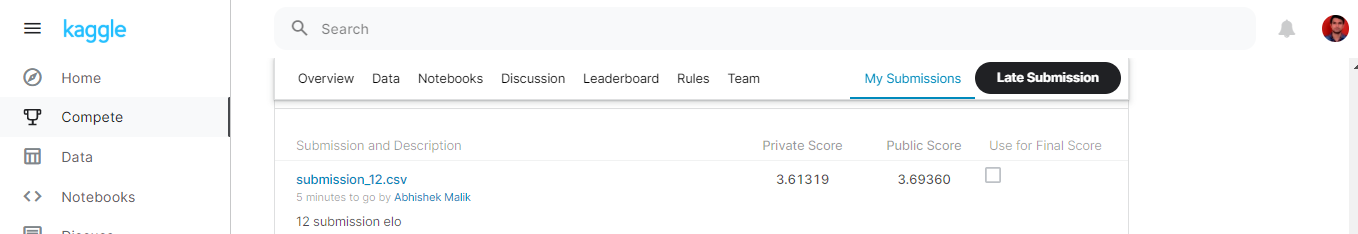

In [ ]:
from IPython.display import Image
print("private score after Submission in kaggle")
Image("/content/Screenshot (253).png")

 score is in top 10% in kaggle leaderboard
This rank have the score from the total participant which is 4127
this is my private score in kaggle


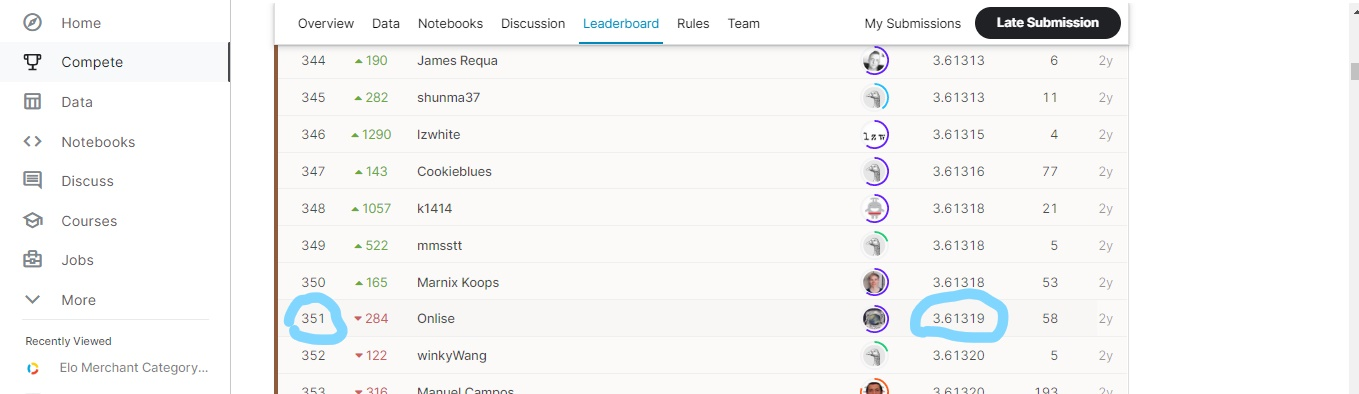

In [ ]:
from IPython.display import Image

print(" score is in top 10% in kaggle leaderboard")
print('This rank have the score from the total participant which is 4127')
print("this is my private score in kaggle")
Image("/content/Screenshot (254)_LI.jpg")